In [1]:
import psycopg2
import pandas as pd
conn = psycopg2.connect(database="bw", user="user9",
    password="Y7aMlL1x", host="88.212.254.23", port=5432)

In [2]:
cur = conn.cursor()

since there is no lead creation data, let's consider the first payment date to be the Lead Creation milestone 

In [4]:
cur.execute("""
            with first_payments as (
                select client_id, min(payment_date) as first_date
                from marketing_payments
                group by client_id
            ),
            attr as (
                select distinct v.client_id, 
                first_value(concat(raw_source_medium, ' | ', raw_campaign)) over(partition by v.client_id order by created_at) as first_channel,
                last_value(concat(raw_source_medium, ' | ', raw_campaign)) over(partition by v.client_id order by created_at) as last_channel
                from marketing_visits v
                join first_payments p on v.client_id = p.client_id and cast(v.created_at as date) <= p.first_date
            ),
            cte as (
                select payment_amount/2 as payment_amount, first_channel as channel
                from marketing_payments p join attr on p.client_id = attr.client_id
                union all
                select payment_amount/2 as payment_amount, last_channel as channel
                from marketing_payments p join attr on p.client_id = attr.client_id
                )
            select channel, sum(payment_amount) as amount
            from cte
            group by channel
            order by amount desc
            """)
df = pd.DataFrame(cur.fetchall(), columns=['channel', 'payment_amount'])

In [9]:
df

,channel,payment_amount
0,google / organic | (not set),4426.662501
1,(direct) / (none) | (not set),2799.107489
2,google / cpc | top_style_jeans_search,990.961008
3,google / cpc | top_style_all_search,737.875174
4,facebook / post | were-happy-to-announce-we-ha...,356.277030
5,mail.google.com / referral | (not set),341.550306
6,xero.com / referral | (not set),282.711842
7,google / cpc | top_style_2024_search,245.692250
8,google / cpc | hoodie_target_pullover_asia_search,223.863323
9,google / cpc | hoodie_target_pullover_all2_search,187.444817


We can see that the most profitable source is organic (both the first and the second channels in the table) - 58% of revenue.

This is partially explained by the attribution. People tend to go directly to the website more often when they have been there before. So if the attribution was purely first click we could have seen a smaller share.

In [58]:
df.payment_amount.iloc[:2].sum()/df.payment_amount.sum()

0.5795068609667563

The second most profitable source is advertising. Together with organics they bring around 85% of revenue

In [63]:
df[df.channel.apply(lambda x: 'google / cpc' in x)].payment_amount.sum()/df.payment_amount.sum()

0.26755598468897324

Now let's compute monthly data (I will aggregate monthly with an offset to get comparable numbers)

In [6]:
cur.execute("""
            with first_payments as (
                select client_id, min(payment_date) as first_date
                from marketing_payments
                group by client_id
            ),
            attr as (
                select distinct v.client_id, 
                first_value(concat(raw_source_medium, ' | ', raw_campaign)) over(partition by v.client_id order by created_at) as first_channel,
                last_value(concat(raw_source_medium, ' | ', raw_campaign)) over(partition by v.client_id order by created_at) as last_channel
                from marketing_visits v
                join first_payments p on v.client_id = p.client_id and cast(v.created_at as date) <= p.first_date
            ),
            cte as (
                select payment_amount/2 as payment_amount, payment_date, first_channel as channel
                from marketing_payments p join attr on p.client_id = attr.client_id
                union all
                select payment_amount/2 as payment_amount, payment_date, last_channel as channel
                from marketing_payments p join attr on p.client_id = attr.client_id
                )
            select case when payment_date >= (select max(payment_date) - interval '1 months' from marketing_payments) then '3 month'
            when payment_date >= (select max(payment_date) - interval '2 months' from marketing_payments) then '2 month' else '1 month' end as payment_period, 
            channel, sum(payment_amount) as amount
            from cte
            where payment_date >= (select max(payment_date) - interval '3 months' from marketing_payments)
            group by payment_period, channel
            order by payment_period asc, amount desc
            """)
df_weekly = pd.DataFrame(cur.fetchall(), columns=['month','channel', 'payment_amount'])

The trend seems to be unstable but still good considering the last month

<AxesSubplot:xlabel='month'>

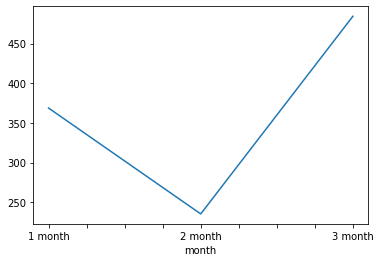

In [7]:
df_weekly.groupby('month').sum().payment_amount.plot()

If we focus on advertising we can see that the trend there is better

<AxesSubplot:xlabel='month'>

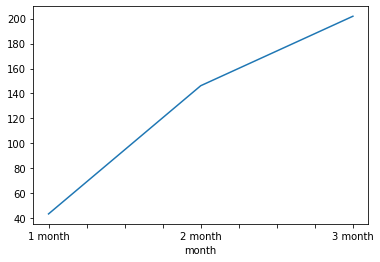

In [111]:
df_weekly[df_weekly.channel.apply(lambda x: 'google / cpc' in x)].groupby('month').sum().payment_amount.plot()

In [45]:
cur.close()